In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as ssp
import scipy.linalg as salg
from scipy.sparse.linalg import spsolve, splu, inv
from scipy.sparse.csgraph import reverse_cuthill_mckee
from collections.abc import Callable
from sksparse.cholmod import cholesky

In [2]:
#Defining the constants
P = 6		#Power of two
N = 2**P	#Number of subdivisions
U0 = 0.01 	#The border constant we might need to use?
h = 1/N		#Discretisation step

DEBUG = True

In [3]:

def get_elem_mat(N: int, dimension: str) -> ssp.csr_matrix:
	"""Creates the element matrix 'Ah' for the 2D or 3D discrete laplaciaan

	Parameters
	----------
	N : int
	    Number of points in a direction of the grid
	dimension : str
	    2D/3D for two/three-dimensional discrete laplacian

	Returns
	-------
	ssp.csc_matrix
	    The element matrix Ah
	"""	
	one_dim_diff = 2*np.eye((N))-np.eye((N), k=-1)-np.eye((N), k=1)


	ONE_DIM_DIFF	= ssp.csr_matrix(one_dim_diff.astype(int))
	ID 		= ssp.csr_matrix(np.eye(N).astype(int))

	x_dim_diff = (1/(h**2) * ssp.kron(ONE_DIM_DIFF,ID))
	y_dim_diff = (1/(h**2) * ssp.kron(ID, ONE_DIM_DIFF))

	X_DIM_DIFF 	= ssp.csr_matrix(x_dim_diff.astype(int))
	Y_DIM_DIFF 	= ssp.csr_matrix(y_dim_diff.astype(int))
	TWO_LAPLACE 	= ssp.csr_matrix(x_dim_diff + y_dim_diff)

	one_dim_diff = None
	x_dim_diff = None
	y_dim_diff = None

	if dimension == "2D":
		return TWO_LAPLACE

	elif dimension == "3D":	
		z_dim_diff = (1/(h**2)*(
			ssp.kron(ID,
				ssp.kron(ID, ONE_DIM_DIFF)
				)
			)
		)

		Z_DIM_DIFF 	= ssp.csr_matrix(z_dim_diff.astype(int))
		z_dim_diff = None

		THREE_LAPLACE = (ssp.kron(X_DIM_DIFF, ID) 
				+ssp.kron(Y_DIM_DIFF, ID)
				+Z_DIM_DIFF)
		
		return THREE_LAPLACE

	else:
		raise ValueError('string: Dimension, either "2D" or "3D"')


In [4]:
def build_forcing_vector(lin_spaces: list,
			 internal_fun,
			 boundary_fun  = None
			 ) -> np.ndarray:
	"""Builds the RHS of the linear system for a arbitray-dimensional laplacian

	Parameters
	----------
	lin_spaces : list
	    List of arrays of points that will be used to build the meshgrid
	internal_fun : Callable[list[float]]
	    Function that takes n-dimensional coordinate arrays and returns the value of the forcing at that coordinate
	boundary_fun : Callable[list[float]]
	    Function that takes n-dimensional coordinate arrays and returns the value of the forcing at that boundary coordinate

	Returns
	-------
	np.ndarray
	    The forcing vector
	"""	
	grids = np.meshgrid(*lin_spaces)
	internal_forcing_array = internal_fun(*grids)
	if boundary_fun == None:
		def boundary_fun(*grids):
			return 0*grids[0]
			
	boundary_forcing_array = boundary_fun(*grids)

	dims = len(lin_spaces)
	mask = tuple([slice(1,-1)]*dims)
	forcing, forcing[mask] = boundary_forcing_array, internal_forcing_array[mask]
	print(mask)

	forcing_vector = forcing.flatten()
	return forcing_vector


In [5]:
%%time

def int_forc_fun(x,y):
	return (x**2 + y**2)*np.sin(x*y)

def bound_forc_fun(x,y):
	return np.sin(x*y)

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)
z = np.linspace(0,1,N+1)

X, Y = np.meshgrid(x,y)


CPU times: user 603 µs, sys: 360 µs, total: 963 µs
Wall time: 680 µs


In [6]:
vecF = build_forcing_vector([x,y], int_forc_fun, bound_forc_fun)

(slice(1, -1, None), slice(1, -1, None))


In [7]:
%%time
TWO_LAPLACE = get_elem_mat(N+1, "2D")

CPU times: user 6.86 ms, sys: 1.35 ms, total: 8.2 ms
Wall time: 5.76 ms


In [8]:
%%time
#Manipulating the 2D-laplacian and the forcing vector to obey boundary elements
#By selecting the boundary points
Xval, Yval = X.ravel(), Y.ravel()

boundary_list = np.squeeze(
	np.where(
		(Xval==x[0]) | (Xval==x[-1]) | (Yval==y[0]) | (Yval==y[-1])
	)
);

SPARSE_ID = ssp.eye((N+1)**2).tocsr()
for row in boundary_list:
	TWO_LAPLACE[row,:] = SPARSE_ID[row,:]



CPU times: user 76.5 ms, sys: 0 ns, total: 76.5 ms
Wall time: 74.4 ms


In [9]:
size = (N+1)**2

TWO_LAPLACE = TWO_LAPLACE.tocsc()
P_MATRIX = ssp.csc_matrix((size,size))


TWO_LAPLACE.shape


(4225, 4225)

In [10]:
ONES = ssp.csr_matrix((size,size))
ONES[boundary_list,boundary_list] = 1

print(ONES.shape)


(4225, 4225)


/home/jeroensangers/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [11]:
ONES
print(ONES)

  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
  (10, 10)	1.0
  (11, 11)	1.0
  (12, 12)	1.0
  (13, 13)	1.0
  (14, 14)	1.0
  (15, 15)	1.0
  (16, 16)	1.0
  (17, 17)	1.0
  (18, 18)	1.0
  (19, 19)	1.0
  (20, 20)	1.0
  (21, 21)	1.0
  (22, 22)	1.0
  (23, 23)	1.0
  (24, 24)	1.0
  :	:
  (4200, 4200)	1.0
  (4201, 4201)	1.0
  (4202, 4202)	1.0
  (4203, 4203)	1.0
  (4204, 4204)	1.0
  (4205, 4205)	1.0
  (4206, 4206)	1.0
  (4207, 4207)	1.0
  (4208, 4208)	1.0
  (4209, 4209)	1.0
  (4210, 4210)	1.0
  (4211, 4211)	1.0
  (4212, 4212)	1.0
  (4213, 4213)	1.0
  (4214, 4214)	1.0
  (4215, 4215)	1.0
  (4216, 4216)	1.0
  (4217, 4217)	1.0
  (4218, 4218)	1.0
  (4219, 4219)	1.0
  (4220, 4220)	1.0
  (4221, 4221)	1.0
  (4222, 4222)	1.0
  (4223, 4223)	1.0
  (4224, 4224)	1.0


In [12]:
print(SPARSE_ID)

  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
  (10, 10)	1.0
  (11, 11)	1.0
  (12, 12)	1.0
  (13, 13)	1.0
  (14, 14)	1.0
  (15, 15)	1.0
  (16, 16)	1.0
  (17, 17)	1.0
  (18, 18)	1.0
  (19, 19)	1.0
  (20, 20)	1.0
  (21, 21)	1.0
  (22, 22)	1.0
  (23, 23)	1.0
  (24, 24)	1.0
  :	:
  (4200, 4200)	1.0
  (4201, 4201)	1.0
  (4202, 4202)	1.0
  (4203, 4203)	1.0
  (4204, 4204)	1.0
  (4205, 4205)	1.0
  (4206, 4206)	1.0
  (4207, 4207)	1.0
  (4208, 4208)	1.0
  (4209, 4209)	1.0
  (4210, 4210)	1.0
  (4211, 4211)	1.0
  (4212, 4212)	1.0
  (4213, 4213)	1.0
  (4214, 4214)	1.0
  (4215, 4215)	1.0
  (4216, 4216)	1.0
  (4217, 4217)	1.0
  (4218, 4218)	1.0
  (4219, 4219)	1.0
  (4220, 4220)	1.0
  (4221, 4221)	1.0
  (4222, 4222)	1.0
  (4223, 4223)	1.0
  (4224, 4224)	1.0


In [13]:
print(boundary_list)

[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65  129  130  194  195
  259  260  324  325  389  390  454  455  519  520  584  585  649  650
  714  715  779  780  844  845  909  910  974  975 1039 1040 1104 1105
 1169 1170 1234 1235 1299 1300 1364 1365 1429 1430 1494 1495 1559 1560
 1624 1625 1689 1690 1754 1755 1819 1820 1884 1885 1949 1950 2014 2015
 2079 2080 2144 2145 2209 2210 2274 2275 2339 2340 2404 2405 2469 2470
 2534 2535 2599 2600 2664 2665 2729 2730 2794 2795 2859 2860 2924 2925
 2989 2990 3054 3055 3119 3120 3184 3185 3249 3250 3314 3315 3379 3380
 3444 3445 3509 3510 3574 3575 3639 3640 3704 3705 3769 3770 3834 3835
 3899 3900 3964 3965 4029 4030 4094 4095 4159 4160 4161 4162 4163 4164
 4165 

In [14]:
%%time

ZEROES = ssp.csc_matrix((size,size))

P_MATRIX[:, boundary_list] = TWO_LAPLACE[:, boundary_list]
TWO_LAPLACE[:,boundary_list] = ZEROES[:,boundary_list]

print(type(TWO_LAPLACE))

TWO_LAPLACE = (TWO_LAPLACE + ONES)
P_MATRIX = (P_MATRIX - ONES)

print(type(TWO_LAPLACE))

<class 'scipy.sparse.csc.csc_matrix'>
<class 'scipy.sparse.csc.csc_matrix'>
CPU times: user 16.8 ms, sys: 18.5 ms, total: 35.3 ms
Wall time: 32.4 ms


/home/jeroensangers/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [15]:
print(P_MATRIX)

  (66, 1)	-4096.0
  (67, 2)	-4096.0
  (68, 3)	-4096.0
  (69, 4)	-4096.0
  (70, 5)	-4096.0
  (71, 6)	-4096.0
  (72, 7)	-4096.0
  (73, 8)	-4096.0
  (74, 9)	-4096.0
  (75, 10)	-4096.0
  (76, 11)	-4096.0
  (77, 12)	-4096.0
  (78, 13)	-4096.0
  (79, 14)	-4096.0
  (80, 15)	-4096.0
  (81, 16)	-4096.0
  (82, 17)	-4096.0
  (83, 18)	-4096.0
  (84, 19)	-4096.0
  (85, 20)	-4096.0
  (86, 21)	-4096.0
  (87, 22)	-4096.0
  (88, 23)	-4096.0
  (89, 24)	-4096.0
  (90, 25)	-4096.0
  :	:
  (4134, 4199)	-4096.0
  (4135, 4200)	-4096.0
  (4136, 4201)	-4096.0
  (4137, 4202)	-4096.0
  (4138, 4203)	-4096.0
  (4139, 4204)	-4096.0
  (4140, 4205)	-4096.0
  (4141, 4206)	-4096.0
  (4142, 4207)	-4096.0
  (4143, 4208)	-4096.0
  (4144, 4209)	-4096.0
  (4145, 4210)	-4096.0
  (4146, 4211)	-4096.0
  (4147, 4212)	-4096.0
  (4148, 4213)	-4096.0
  (4149, 4214)	-4096.0
  (4150, 4215)	-4096.0
  (4151, 4216)	-4096.0
  (4152, 4217)	-4096.0
  (4153, 4218)	-4096.0
  (4154, 4219)	-4096.0
  (4155, 4220)	-4096.0
  (4156, 4221)	-4096.0

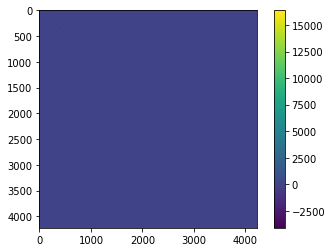

In [16]:
plt.imshow(TWO_LAPLACE.toarray())
plt.colorbar()

In [17]:
TWO_LAPLACE.shape

(4225, 4225)

In [18]:
pm = P_MATRIX

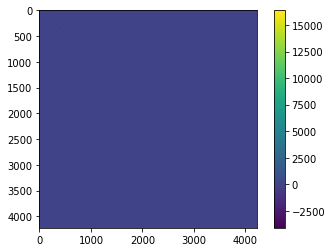

In [19]:
P_MATRIX.shape
plt.imshow(TWO_LAPLACE.toarray())
plt.colorbar()

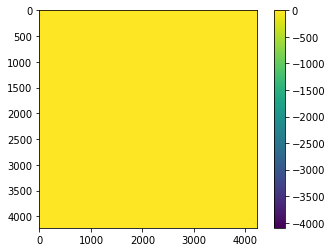

In [20]:
plt.imshow(P_MATRIX.toarray())
plt.colorbar()

In [21]:
#Building u0
U0 = np.sin(X*Y)
u0 = U0.flatten()
to_subtract = P_MATRIX.dot(u0)


In [22]:
vecF = np.subtract(vecF, to_subtract)

In [23]:
TWO_LAPLACE.shape

(4225, 4225)

In [24]:
print(vecF)

[0.         0.         0.         ... 0.82417844 0.83292639 0.84147098]


In [25]:
%%time
u = spsolve(TWO_LAPLACE, vecF.T)

CPU times: user 9.86 ms, sys: 0 ns, total: 9.86 ms
Wall time: 8.73 ms


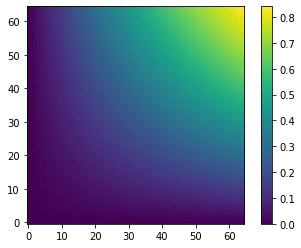

In [26]:
array_u = u.reshape((N+1,N+1))
plt.imshow(array_u, origin='lower');
plt.colorbar()

In [27]:
u_ex = np.sin(X*Y)
vec_u_ex = u_ex.flatten()

In [28]:
error = np.sqrt(h**2 *np.sum((vec_u_ex-u)**2))
print("h**2: {:.5f}\t error: {:.5f}".format(h**2, error))
print('relative error: {:.4f}\t [h**2]'.format(error/(h**2)))

h**2: 0.00024	 error: 0.00000
relative error: 0.0004	 [h**2]


In [29]:
def decomp_lu(M: ssp.csc_matrix) -> ssp.csc_matrix:
	"""Creates the sparse lower matrix of the LU decomposition of M

	Parameters
	----------
	M : ssp.csc_matrix
	    The matrix to LU decompose such that L@U = M

	Returns
	-------
	ssp.csc_matrix
	    The sparse lower matrix L
	"""
	#In this code block all fully uppercase variables are sparse matrices
	shape_m = M.shape
	ID = ssp.eye(shape_m[0])
	ZEROES = ssp.csc_matrix(shape_m)

	SUM = ID.copy()
	for k in range(0, shape_m[1]):
		Akk = M[k,k]
		VEC = M[:,k] / Akk
		VEC[0: k+1] = ZEROES[0:k+1, 0]

		EK = ZEROES[:,0].copy()
		EK[k] = 1

		ADD = VEC * EK.T
		SUM += ADD
	
	L = SUM
	U = spsolve(SUM, M)

	return L, U

In [30]:
from tqdm import tqdm

In [31]:
##Mocht je hier een error krijgen dan moet je waarschijnlijk even het volgende veranderen
## tqdm(range(...)) -> range(...)


def decomp_cholesky(M: ssp.csc_matrix) -> ssp.csc_matrix:
	"""Creates the sparse lower triangular matrix C that results from cholesky
	decomposition.

	Parameters
	----------
	M : ssp.csc_matrix
	    The matrix M such that cholesky decomposition yields C, scuh that 
	    C@C.T == M

	Returns
	-------
	ssp.csc_matrix
	    The sparse lower triangular matrix C
	"""	
	shape_m = M.shape
	ZEROES = ssp.lil_matrix(shape_m)
	C = ssp.lil_matrix(shape_m)
	TMP = M.copy().tolil()

	for col in tqdm(range(0, shape_m[1])): #Hierzo
		C[col,col] = np.sqrt((TMP[col,col] - ( C[col,0:col].power(2) ).sum()))
		TMP[col,col] = C[col,col]

		PROD = TMP[col+1:,0:col]*TMP[col,0:col].T

		SUM = PROD.sum(axis=1)

		pref = 1/(C[col,col])

		C[col+1:,col] = pref*(TMP[col+1:,col] - SUM)
		TMP[col+1:,col] = C[col+1:, col]

		C[col,col+1:] = ZEROES[col,col+1:]

	return C


In [32]:
TWO_LAPLACE.tocsc()

<4225x4225 sparse matrix of type '<class 'numpy.float64'>'
	with 19849 stored elements in Compressed Sparse Column format>

In [33]:
"""
L, U = decomp_lu(TWO_LAPLACE)
D = ssp.diags(U.diagonal(k=0))

plt.imshow(D.toarray())
plt.colorbar()

sqrtD = D.sqrt()

C = L@sqrtD
"""

'\nL, U = decomp_lu(TWO_LAPLACE)\nD = ssp.diags(U.diagonal(k=0))\n\nplt.imshow(D.toarray())\nplt.colorbar()\n\nsqrtD = D.sqrt()\n\nC = L@sqrtD\n'

In [34]:
#Utest = D@L.T

In [35]:
#np.alltrue(Utest.toarray() == U.toarray())

In [36]:
#LU = L@U

#np.alltrue(TWO_LAPLACE.toarray() == LU.toarray())

In [37]:
#np.all(np.linalg.eigvals(TWO_LAPLACE.toarray())>0)

In [38]:
%%time
##Mocht je een error krijgen, lees dan de comment in de cell hierboven
#C = decomp_cholesky(TWO_LAPLACE)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [39]:
%%time

C_factor = cholesky(TWO_LAPLACE, beta=0, ordering_method='natural')


CPU times: user 23.4 ms, sys: 0 ns, total: 23.4 ms
Wall time: 8.75 ms


In [40]:
C2 = C_factor.L()
P = C_factor.P()

In [41]:
print(P)

[   0    1    2 ... 4222 4223 4224]


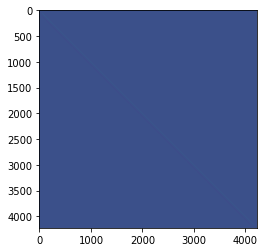

In [42]:
plt.imshow(C2.toarray())

In [43]:
startt = time_ns()
b = spsolve(C2, vecF)
forwt = time_ns() - startt
sol = spsolve(C2.T, b)
backt = time_ns() - startt - forwt
statement = "Forward step took: {:.2f} ms, Backward step took: {:.2f} ms".format(forwt/1e6, backt/1e6)

print(statement)

NameError: name 'time_ns' is not defined

In [ ]:
permut = reverse_cuthill_mckee(TWO_LAPLACE, symmetric_mode=True)
print(permut)

In [ ]:
REDUCED_BAND = TWO_LAPLACE[permut[:,np.newaxis], permut[np.newaxis,:]]

In [ ]:
RED_BAND_FACT = cholesky(TWO_LAPLACE, beta=0, ordering_method='natural')
C = RED_BAND_FACT.L()

In [ ]:
startt = time_ns()
b = spsolve(C, vecF)
forwt = time_ns() - startt
sol = spsolve(C.T, b)
backt = time_ns() - startt - forwt
statement = "Forward step took: {:.2f} ms, Backward step took: {:.2f} ms".format(forwt/1e6, backt/1e6)

print(statement)

In [ ]:
toplot = sol.reshape((N+1,N+1))
plt.imshow(toplot)
plt.colorbar()

In [ ]:
plt.imshow(REDUCED_BAND.toarray())

In [ ]:
#np.alltrue(C.toarray() == C2.toarray())

plt.close()
plt.imshow(C2.toarray())
plt.colorbar()

MAYBE = C2@C2.T
plt.imshow(MAYBE.toarray())
plt.colorbar()

U_MAYBE = spsolve(MAYBE, vecF)

u_maybe = (U_MAYBE).reshape((N+1,N+1))
plt.imshow(u_maybe, origin='lower')
plt.colorbar()

In [ ]:
from time import time_ns

In [ ]:
def sys_solve_chol(f: ssp.csc_matrix, L: ssp.csc_matrix, U: ssp.csc_matrix) -> ssp.csc_matrix:
	LOWER = L #Forward matrix
	UPPER = U #Backward

	startt = time_ns()
	b = spsolve(LOWER, f)
	forwt = time_ns() - startt
	sol = spsolve(UPPER, b)
	backt = time_ns() - startt - forwt

	statement = "Forward step took: {:.2f} ms, Backward step took: {:.2f} ms".format(forwt/1e6, backt/1e6)

	return sol, statement


In [ ]:
%%time

#u, state = sys_solve_chol(vecF, L, U)

#print(state)

In [ ]:
#nonzero counting

nnzA = TWO_LAPLACE.count_nonzero()
nnzA2 = REDUCED_BAND.count_nonzero()
nnzC = C.count_nonzero()
nnzC2 = C2.count_nonzero()

fill_ratio = nnzC / nnzA
fillratio2 = nnzC2 / nnzA2

print(fill_ratio, fillratio2)


In [ ]:
E = -1*ssp.tril(TWO_LAPLACE, k=-1)
F = -1*ssp.triu(TWO_LAPLACE, k=1)
D = ssp.diags(TWO_LAPLACE.diagonal())

In [ ]:
plt.imshow(E.toarray())
plt.colorbar()

In [ ]:
plt.imshow(F.toarray())
plt.colorbar()

In [ ]:
plt.imshow(D.toarray())
plt.colorbar()

In [ ]:
omega = 1.5

MINV = omega*(2-omega) * inv(D - omega* E) @ D @ inv(D - omega*F)

shape = MINV.shape
ID = ssp.csc_matrix(shape)

In [ ]:
u0 = ssp.csr_matrix(np.zeros(shape[0]))
r0 = ssp.csr_matrix(np.ones(shape[0]))
f = ssp.csr_matrix(vecF)

print(vec_u_ex.shape)
print(u0.shape)

epsilon = 1e-5


In [ ]:
def get_norm(vector: ssp.csc_matrix) -> float:
	norm = np.sqrt((vector.power(2)).sum())
	return norm

In [ ]:
"""norm_f = get_norm(f)
norm_r = get_norm(r0)

u = u0.T
r = f.T


i = 0
for i in range(40000):
	u = u + MINV@r
	r = COMP@r

	norm_r = get_norm(r)

	if norm_r / norm_f < epsilon:
		break

print(norm_r/norm_f)
print(i)
"""

COMP = (ID - TWO_LAPLACE@MINV)
A = TWO_LAPLACE

norm_f = get_norm(f)
norm_r = get_norm(r0)

u = u0.T
r = f.T

print(type(MINV))
print(type(r))
print(type(u))

r_norms = np.asarray([norm_r])

i = 0
while not norm_r/norm_f < epsilon:
	u = u + MINV@r
	r = f.T - A@u

	norm_r = get_norm(r)
	r_norms = np.append(r_norms, norm_r)
	if i % 10 == 0:
		print(i, norm_r/norm_f)
	i += 1



u_ssor = u

In [ ]:

COMP = (ID - TWO_LAPLACE@MINV)
A = TWO_LAPLACE

norm_f = get_norm(f)
norm_r = get_norm(r0)

u = u0.T
r = f.T
f = f.T

r_norms = np.asarray([norm_r])
n = A.shape[0]

j = 0
while not norm_r/norm_f < epsilon:
	for i in range(n):
		sigma = u[i]
		u[i] = (f[i] - A[i,0:i]@u[0:i] - A[i,i+1:n]@u[i+1:n])/A[i,i]
		u[i] = (1-omega)*sigma + omega*u[i]
	
	for i in range(n-1,0,-1):
		sigma = u[i]
		u[i] = (f[i] - A[i,0:i]@u[0:i] - A[i,i+1:n]@u[i+1:n])/A[i,i]
		u[i] = (1-omega)*sigma + omega*u[i]
	

	r = f - A@u

	norm_r = get_norm(r)
	r_norms = np.append(r_norms, norm_r)
	if j % 2 == 0:
		print("iteration {:.2f}, norm {:.2e}".format(j,norm_r))
	j += 1
	
u_ssor2 = u


u = u0.T
f = ssp.csc_matrix(vecF).T
A = TWO_LAPLACE
norm_r = get_norm(r0)
norm_f = get_norm(f)
r = r0.T

E = -1*ssp.tril(TWO_LAPLACE, k=-1)
F = -1*ssp.triu(TWO_LAPLACE, k=1)
D = ssp.diags(TWO_LAPLACE.diagonal())

i = 0
while not norm_r/norm_f < epsilon:
	sigma = u
	u = (f + E@u + F@u)
	diag = ssp.csc_matrix(A.diagonal()).T
	
	for idx in range(u.shape[0]):
		u[idx] = u[idx] / diag[idx]

	u = ssp.csc_matrix(u)
	u = (1-omega)*sigma + omega*u
	r = COMP@r
	norm_r = get_norm(r)
	i += 1
	if i % 100 == 0:
		print(norm_r)
	if i == 1000:
		break

u_ssor3 = u
	

In [ ]:
print(i)

In [ ]:

len(r_norms)

In [ ]:
plt.plot(np.arange(len(r_norms)), r_norms)
plt.semilogy()
plt.ylabel(r"$\frac{|r_m|_2}{|f^h|_2}$")
plt.xlabel(r"iteration $m$")
plt.show()

In [ ]:
"""
norm_f = get_norm(f)
norm_r = get_norm(r0)

u = u0.T
r = f.T

COMP = (ID - TWO_LAPLACE@MINV)

i = 0
A = TWO_LAPLACE
for iter in range(2000):
	uold = u
	for i in range(shape[0]):
		sub1 = A[i,:i]@u[:i]
		print(sub1.shape)
		sub2 = A[i,i+1:]@u[i+1:]/A[i,i]
		print(sub2.shape)
		u[i] = f[i] - sub1[0,0] - sub2[0,0]
	u = (1-omega)*uold + omega*u

	if norm_r / norm_f < epsilon:
		break
"""

In [ ]:
plt.imshow(vec_u_ex.reshape((N+1,N+1)))
plt.colorbar()

In [ ]:
plt.imshow((u_ssor.toarray()).reshape((N+1,N+1)))
plt.colorbar()

In [ ]:
#Preconditioned Conjugate-Gradient
u = u0.T
r = f.T

norm_f = get_norm(f)
norm_r = get_norm(r0)

r_prev = 0
z_prev = 0
p = 0

i = 0
while not norm_r/norm_f < epsilon:
	r_pprev = r_prev
	r_prev = r
	z_pprev = z_prev
	p_prev = p
	
	z_prev = MINV@r_prev

	if i == 0:
		p = z_prev
	else:
		beta = (r_prev.T @ z_prev)/(r_pprev.T @ z_pprev)
		p = z_prev + beta[0,0]*p_prev
	
	alpha = (r_prev.T @ z_prev)/(p.T @ TWO_LAPLACE @ p)
	u += alpha[0,0]*p
	r += -alpha[0,0]*(TWO_LAPLACE@p)
	i += 1
	norm_r = get_norm(r)

print(i)
u_preccg = u

In [ ]:
plt.imshow((u_preccg.toarray()).reshape((N+1,N+1)))
plt.colorbar()

In [ ]:
u_preccg = u_preccg.toarray().reshape((N+1,N+1))
u_ssor = u_ssor.toarray().reshape((N+1,N+1))

In [ ]:
plt.imshow(u_ssor/u_preccg)
plt.colorbar()